In [1]:
import straindesign as sd

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cobra
import logging
logging.basicConfig(level=logging.INFO)
import pandas as pd
pd.set_option('display.float_format', lambda x: f'{x:.3f}')

In [3]:
from syn_elong import model
from syn_elong.media import m9_media

Set parameter Username


INFO:gurobipy.gurobipy:Set parameter Username


Set parameter GURO_PAR_SPECIAL


INFO:gurobipy.gurobipy:Set parameter GURO_PAR_SPECIAL


Set parameter TokenServer to value "leghorn"


INFO:gurobipy.gurobipy:Set parameter TokenServer to value "leghorn"


In [4]:
model.medium = m9_media
consistent_model = cobra.flux_analysis.fastcc(model)
consistent_model.mediu = m9_media

INFO:cobra.medium.boundary_types:Compartment `e` sounds like an external compartment. Using this one without counting boundary reactions.


Read LP format model from file C:\Users\pino216\AppData\Local\Temp\tmp8gkya95v.lp


INFO:gurobipy.gurobipy:Read LP format model from file C:\Users\pino216\AppData\Local\Temp\tmp8gkya95v.lp


Reading time = 0.02 seconds


INFO:gurobipy.gurobipy:Reading time = 0.02 seconds


: 924 rows, 2030 columns, 8354 nonzeros


INFO:gurobipy.gurobipy:: 924 rows, 2030 columns, 8354 nonzeros


In [5]:
with model:
    model.medium = m9_media
    sol = sd.fba(model, obj='BIOMASS__1', obj_sense='max', pfba =False)
    print(f"Maximum possible BIOMASS__1 synthesis rate: {sol.objective_value}.")
    sol = sd.fba(model, obj='EX_sucr_e', obj_sense='max', pfba =False)
    print(f"Maximum possible EX_sucr_e synthesis rate: {sol.objective_value}.")
with consistent_model as m:
    m.medium = m9_media
    sol = sd.fba(m, obj='BIOMASS__1', obj_sense='max', pfba =False)
    print(f"Maximum possible BIOMASS__1 synthesis rate: {sol.objective_value}.")
    sol = sd.fba(m, obj='EX_sucr_e', obj_sense='max', pfba =False)
    print(f"Maximum possible EX_sucr_e synthesis rate: {sol.objective_value}.")

INFO:cobra.medium.boundary_types:Compartment `e` sounds like an external compartment. Using this one without counting boundary reactions.
INFO:cobra.medium.boundary_types:Compartment `e` sounds like an external compartment. Using this one without counting boundary reactions.


Maximum possible BIOMASS__1 synthesis rate: 4.595313108153102.
Maximum possible EX_sucr_e synthesis rate: 16.66666666666667.
Maximum possible BIOMASS__1 synthesis rate: 4.595313108153135.
Maximum possible EX_sucr_e synthesis rate: 16.666666666666686.


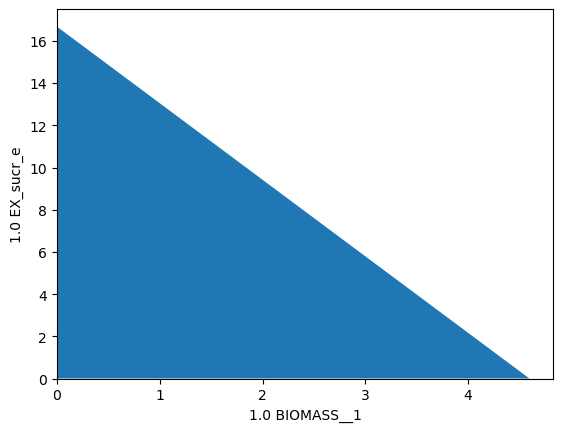

In [6]:
datapoints, triang, plot1 = sd.plot_flux_space(
    model,
    ('BIOMASS__1', 'EX_sucr_e'),
    show=False
);

In [7]:
def view_with_changes(changed_model):
    datapoints, triang, plot1 = sd.plot_flux_space(
        model,
        ('BIOMASS__1', 'EX_sucr_e'),
        show=False
    );

    plot1.set_facecolor('green')
    plot1.set_edgecolor('green')

    _, _,plot2 = sd.plot_flux_space(
        changed_model,
        ('BIOMASS__1', 'EX_sucr_e'),
        show=False
    );
    plot2.set_facecolor('red')
    plot2.set_edgecolor('red')
    # adjust axes limits and show plot
    plot2.axes.set_xlim(0, 1.05*max([a[0] for a in datapoints]))
    plot2.axes.set_ylim(0, 1.05*max([a[1] for a in datapoints]))
    plt.show()

In [8]:
module_suppress = sd.SDModule(
    consistent_model,
    sd.names.SUPPRESS,
    constraints='EX_sucr_e >= 6.0'
)

module_protect  = sd.SDModule(
    consistent_model,
    sd.names.PROTECT,
    constraints='BIOMASS__1>=.2'
)

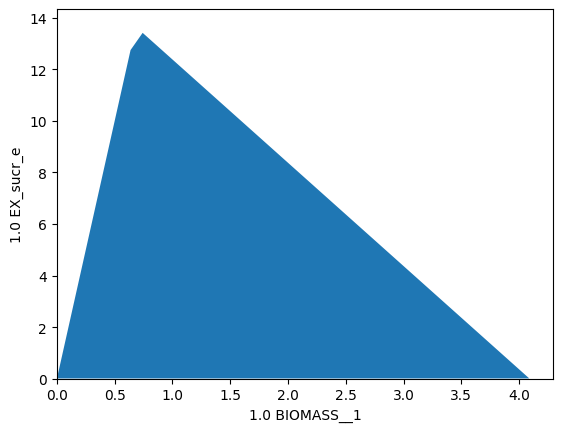

In [9]:
_,          _,      plot3 = sd.plot_flux_space(consistent_model,
                                               ('BIOMASS__1','EX_sucr_e'),
                                               # The sign of the glucose exchange reaction is flipped since
                                               # reaction is defined in the direction of secretion.
                                               constraints=['EX_sucr_e - 20 BIOMASS__1 <= 0',
                                                            'BIOMASS__1 >= 0.01'],
                                               show=False);

In [8]:
rxn_cost = {}
for rxn in consistent_model.reactions:
    if rxn.id.startswith('EX_') or rxn.id.startswith('BIOMASS_') or\
            rxn.id.startswith('SK_') or rxn.id.startswith('PHOA') or\
            rxn.id.startswith('DM_') or rxn.id.startswith('SK_'):
        continue
    if rxn.gene_reaction_rule == '':
        continue
    else:
        rxn_cost[rxn.id] = 1
rxn_cost.pop('BCT1_syn')

1

In [ ]:
from syn_elong.strain_design_simplified import  StrainDesign
# Compute strain designs
with consistent_model as m:
    module_suppress = sd.SDModule(
        m,
        sd.names.SUPPRESS,
        constraints=['EX_sucr_e - 4 BIOMASS__1 <= 0',
                     'BIOMASS__1 >= 0.01']
    )
    module_protect  = sd.SDModule(
        m,
        sd.names.PROTECT,
        constraints='BIOMASS__1>=.1'
    )
    module_tilted_optknock = sd.SDModule(m, sd.names.OPTKNOCK,
                                         inner_objective='BIOMASS__1 ',
                                         outer_objective='EX_sucr_e',
                                         constraints=['BIOMASS__1  >= 0.2', 'EX_sucr_e >=3'])
    module_optcouple = sd.SDModule(m, sd.names.OPTCOUPLE,
                                   inner_objective='BIOMASS__1',
                                   prod_id='EX_sucr_e',
                                   min_gcp=0.1)
    sd_helper = StrainDesign(
        m,
        # sd_modules=[module_suppress, module_protect],
        sd_modules=[module_tilted_optknock],
        ko_cost=rxn_cost,
        # gene_kos=True,
    )

    sols = sd_helper.run(max_solutions=10, max_cost=5, time_limit=300, solution_approach=sd.names.ANY)

In [3]:


with consistent_model as m:
    module_suppress = sd.SDModule(
        m,
        sd.names.SUPPRESS,
        constraints=['EX_sucr_e - 4 BIOMASS__1 <= 0',
                     'BIOMASS__1 >= 0.01']
    )
    module_protect  = sd.SDModule(
        m,
        sd.names.PROTECT,
        constraints='BIOMASS__1>=.1'
    )
    sd_helper = StrainDesign(
        m,
        sd_modules = [module_suppress, module_protect],
        # gene_kos=False,
        ko_cost=rxn_cost,
        solution_approach = sd.names.ANY
    )
    sols = sd_helper.run(max_solutions=5, max_cost=10, time_limit=60, solution_approach=sd.names.ANY)

NameError: name 'consistent_model' is not defined

In [211]:
sols.sd_cost

[4.0, 4.0, 4.0]

In [212]:

# Print solutions
print(f"One compressed solution with cost {sols.sd_cost[0]} found and "+\
      f"expanded to {len(sols.reaction_sd)} solutions in the uncompressed netork.")
print(f"Example knockout set: {[s for s in sols.reaction_sd[0]]}")

One compressed solution with cost 4.0 found and expanded to 3 solutions in the uncompressed netork.
Example knockout set: ['PCXHtpp', 'BCT1_syn', 'CYTBD4cm', 'NTRARf2']


In [ ]:
solutions = sols.reaction_sd

In [9]:
rxns = [
    {'CYTBD4cm': -1.0, 'BCT1_syn': -1.0, 'PCXHtpp': -1.0, 'NTRIRfx': -1.0},
    {'CYTBD4cm': -1.0, 'BCT1_syn': -1.0, 'PCXHtpp': -1.0, 'NTRARf2': -1.0},
    {'CYTBD4cm': -1.0, 'BCT1_syn': -1.0, 'PCXHtpp': -1.0, 'NO3abcpp': -1.0},
    {'CYTBD4cm': -1.0, 'BCT1_syn': -1.0, 'PCXHtpp': -1.0, 'GND': -1.0, 'PSP_L': -1.0},
    {'CYTBD4cm': -1.0, 'BCT1_syn': -1.0, 'PCXHtpp': -1.0, 'GND': -1.0, 'PGCD': -1.0},
    {'CYTBD4cm': -1.0, 'BCT1_syn': -1.0, 'PCXHtpp': -1.0, 'GND': -1.0, 'PSERT': -1.0},
    {'CYTBD4cm': -1.0, 'BCT1_syn': -1.0, 'PCXHtpp': -1.0, 'G6PDH2r': -1.0, 'PSP_L': -1.0},
    {'CYTBD4cm': -1.0, 'BCT1_syn': -1.0, 'PCXHtpp': -1.0, 'G6PDH2r': -1.0, 'PGCD': -1.0},
    {'CYTBD4cm': -1.0, 'BCT1_syn': -1.0, 'PCXHtpp': -1.0, 'G6PDH2r': -1.0, 'PSERT': -1.0},
    {'CYTBD4cm': -1.0, 'BCT1_syn': -1.0, 'PCXHtpp': -1.0, 'PGL': -1.0, 'PSP_L': -1.0},
    {'CYTBD4cm': -1.0, 'BCT1_syn': -1.0, 'PCXHtpp': -1.0, 'PGL': -1.0, 'PGCD': -1.0},
    {'CYTBD4cm': -1.0, 'BCT1_syn': -1.0, 'PCXHtpp': -1.0, 'PGL': -1.0, 'PSERT': -1.0},
    {'NDHPQRcm': -1.0, 'BCT1_syn': -1.0, 'PCXHtpp': -1.0, 'MNHNAtpp': -1.0, 'NTRIRfx': -1.0},
    {'NDHPQRcm': -1.0, 'BCT1_syn': -1.0, 'PCXHtpp': -1.0, 'MNHNAtpp': -1.0, 'NTRARf2': -1.0},
    {'NDHPQRcm': -1.0, 'BCT1_syn': -1.0, 'PCXHtpp': -1.0, 'MNHNAtpp': -1.0, 'NO3abcpp': -1.0},
]

['CYTBD4cm', 'BCT1_syn', 'PCXHtpp', 'GND', 'PSERT']
CYTBD4cm: 4.0 h_c + o2_c + 2.0 pqh2_cm --> 2.0 h2o_c + 4.0 h_p + 2.0 pq_cm
BCT1_syn: atp_c + h2o_c + hco3_p --> adp_c + h_c + hco3_c + pi_c
PCXHtpp: h_c --> h_p
GND: 6pgc_c + nadp_c --> co2_c + nadph_c + ru5p__D_c
PSERT: 3php_c + glu__L_c <=> akg_c + pser__L_c
1.2095054613206664


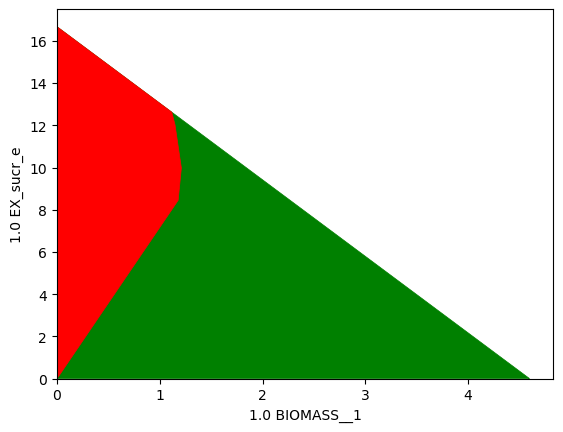

EX_photon670_e   -1000.000
EX_photon690_e    -330.725
PPK               -256.749
Htcx              -227.759
3HAD180           -224.150
                    ...   
STACPSI            780.386
PSICSum           1000.000
ETCPC             1000.000
PSIum             1000.000
PHOA670um         1000.000
Name: fluxes, Length: 444, dtype: float64

In [10]:
def run_with_intervention(intervention):
    with consistent_model as m:
        print([i for i in intervention])
        for i in intervention:
            print(m.reactions.get_by_id(i))
            # if i == 'BCT1_syn':
            #     continue
            # print(i)
            m.reactions.get_by_id(i).lower_bound = 0
            m.reactions.get_by_id(i).upper_bound = 0
#             m.remove_reactions([m.reactions.get_by_id(i)])
        print(m.slim_optimize())
        sol = m.optimize()

        view_with_changes(m)
        return sol.fluxes #sol.reduced_costs, 
red_costs = run_with_intervention(rxns[5])
red_costs[np.abs(red_costs)>0.001].sort_values()

['CYTBD4cm', 'BCT1_syn', 'PCXHtpp', 'GND', 'PSP_L']
CYTBD4cm: 4.0 h_c + o2_c + 2.0 pqh2_cm --> 2.0 h2o_c + 4.0 h_p + 2.0 pq_cm
BCT1_syn: atp_c + h2o_c + hco3_p --> adp_c + h_c + hco3_c + pi_c
PCXHtpp: h_c --> h_p
GND: 6pgc_c + nadp_c --> co2_c + nadph_c + ru5p__D_c
PSP_L: h2o_c + pser__L_c --> pi_c + ser__L_c
1.209505461320687


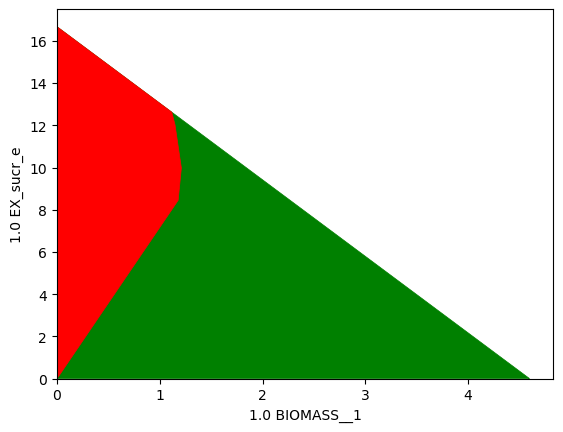

EX_photon670_e   -1000.000
EX_photon690_e    -330.725
PPK               -256.749
Htcx              -227.759
3HAD180           -224.150
                    ...   
STACPSI            780.386
PSICSum           1000.000
ETCPC             1000.000
PSIum             1000.000
PHOA670um         1000.000
Name: fluxes, Length: 444, dtype: float64

In [12]:
red_costs = run_with_intervention(rxns[3])
red_costs[np.abs(red_costs)>0.001].sort_values()

In [14]:
model.metabolites.co2_c

Metabolite identifier,co2_c
Name,CO2 CO2
Memory address,0x25b976d8fa0
Formula,CO2
Compartment,c
In 55 reaction(s),"CPPPGO2, THRPDC, AOXSr2, CMPA_1, TMPPP_1, 3OAS80, NDH_1_4_um_copy2, SEPHCHCS, OGMEACPS, PPND, 3OAS120, DHNANT, ADMDC, DBTS, ACLSa, PC6YM, FDH6, PC6YM_1, CYNL, AOXPBDC, DAPDC, 3OAS100, 3OAS60,..."


In [15]:
consistent_model.reactions.BCT1_syn

Reaction identifier,BCT1_syn
Name,Bicarbonate transport via ABC system (periplasm)
Memory address,0x25b9c0296f0
Stoichiometry,atp_c + h2o_c + hco3_p --> adp_c + h_c + hco3_c + pi_c ATP C10H12N5O13P3 + H2O H2O + Bicarbonate --> ADP C10H12N5O10P2 + H+ + Bicarbonate + Phosphate
GPR,SYNPCC7942_RS07605 and SYNPCC7942_RS07610 and SYNPCC7942_RS07615 and SYNPCC7942_RS07620
Lower bound,0.0
Upper bound,1000.0


In [16]:
consistent_model.metabolites.hco3_p.summary()

INFO:cobra.summary.metabolite_summary:Generating new parsimonious flux distribution.


Percent,Flux,Reaction,Definition
100.00%,100,HCO3tex,hco3_e <=> hco3_p
Percent,Flux,Reaction,Definition
100.00%,-100,H2CO3_NAt_syn,hco3_p + na1_p <=> hco3_c + na1_c


In [17]:
consistent_model.metabolites.atp_c.summary()

INFO:cobra.summary.metabolite_summary:Generating new parsimonious flux distribution.


Percent,Flux,Reaction,Definition
1.83%,26.34,ACKr,ac_c + atp_c <=> actp_c + adp_c
76.98%,1111,ATPSum,3.0 adp_c + 13.0 h_u + 3.0 pi_c <=> 3.0 atp_c + 3.0 h2o_c + 10.0 h_c
19.47%,281,PPK,atp_c + pi_c <=> adp_c + ppi_c
0.00%,0.008233,PPK2,atp_c + ppi_c <=> adp_c + pppi_c
1.73%,24.93,PYK,adp_c + h_c + pep_c --> atp_c + pyr_c
0.00%,0.02428,URIDK2r,atp_c + dump_c <=> adp_c + dudp_c
Percent,Flux,Reaction,Definition
15.12%,-218.2,AACPS6,ACP_c + atp_c + ocdca_c --> amp_c + ocdcaACP_c + ppi_c
1.03%,-14.82,ACCOAC,accoa_c + atp_c + hco3_c --> adp_c + h_c + malcoa_c + pi_c
1.87%,-27.02,ACS,ac_c + atp_c + coa_c --> accoa_c + amp_c + ppi_c


In [ ]:
consistent_model.reactions.HCO3E_1_cx 

In [72]:
consistent_model.reactions.HCO3tcx 

Reaction identifier,HCO3tcx
Name,Bicarbonate transport to carboxyzome
Memory address,0x0258eb887ac0
Stoichiometry,hco3_c --> hco3_cx Bicarbonate --> Bicarbonate
GPR,
Lower bound,0.0
Upper bound,1000.0


In [71]:
consistent_model.metabolites.hco3_cx

Metabolite identifier,hco3_cx
Name,Bicarbonate
Memory address,0x0258eb7764a0
Formula,CHO3
Compartment,cx
In 2 reaction(s),"HCO3tcx, HCO3E_1_cx"


In [24]:
for i in consistent_model.metabolites.hco3_c.reactions:
    print(i)

PEPC: hco3_c + pep_c --> oaa_c + pi_c
NDH_1_4_um_copy1: co2_c + 2.0 fdxrd_c + h2o_c + 4.0 h_c + pq_um --> 2.0 fdxox_c + 3.0 h_u + hco3_c + pqh2_um
H2CO3_NAt_syn: hco3_p + na1_p <=> hco3_c + na1_c
BCT1_syn: atp_c + h2o_c + hco3_p --> adp_c + h_c + hco3_c + pi_c
ACCOAC: accoa_c + atp_c + hco3_c --> adp_c + h_c + malcoa_c + pi_c
HCO3tcx: hco3_c --> hco3_cx
CBPS: 2.0 atp_c + gln__L_c + h2o_c + hco3_c --> 2.0 adp_c + cbp_c + glu__L_c + 2.0 h_c + pi_c
AIRC2: air_c + atp_c + hco3_c --> 5caiz_c + adp_c + h_c + pi_c


In [20]:
consistent_model.reactions.BCT1_syn 

Reaction identifier,BCT1_syn
Name,Bicarbonate transport via ABC system (periplasm)
Memory address,0x25b9c0296f0
Stoichiometry,atp_c + h2o_c + hco3_p --> adp_c + h_c + hco3_c + pi_c ATP C10H12N5O13P3 + H2O H2O + Bicarbonate --> ADP C10H12N5O10P2 + H+ + Bicarbonate + Phosphate
GPR,SYNPCC7942_RS07605 and SYNPCC7942_RS07610 and SYNPCC7942_RS07615 and SYNPCC7942_RS07620
Lower bound,0.0
Upper bound,1000.0


In [21]:
consistent_model.reactions.H2CO3_NAt_syn 

Reaction identifier,H2CO3_NAt_syn
Name,Bicarbonate transport (Na/HCO3 cotransport periplasme)
Memory address,0x25b9bf756c0
Stoichiometry,hco3_p + na1_p <=> hco3_c + na1_c Bicarbonate + Sodium <=> Bicarbonate + Sodium
GPR,Synpcc7942_1475 or Synpcc7942_0357
Lower bound,-1000.0
Upper bound,1000.0


In [22]:
consistent_model.reactions.HCO3tex 

Reaction identifier,HCO3tex
Name,Bicarbonate transport via diffusion (extracellular to periplasm)
Memory address,0x25b9c05edd0
Stoichiometry,hco3_e <=> hco3_p Bicarbonate <=> Bicarbonate
GPR,
Lower bound,-1000.0
Upper bound,1000.0


In [73]:
consistent_model.reactions.BCT1_syn  

Reaction identifier,BCT1_syn
Name,Bicarbonate transport via ABC system (periplasm)
Memory address,0x0258eb87c730
Stoichiometry,atp_c + h2o_c + hco3_p --> adp_c + h_c + hco3_c + pi_c ATP C10H12N5O13P3 + H2O H2O + Bicarbonate --> ADP C10H12N5O10P2 + H+ + Bicarbonate + Phosphate
GPR,SYNPCC7942_RS07605 and SYNPCC7942_RS07610 and SYNPCC7942_RS07615 and SYNPCC7942_RS07620
Lower bound,0.0
Upper bound,1000.0


['GND', 'PSP_L', 'BCT1_syn']
GND: 6pgc_c + nadp_c --> co2_c + nadph_c + ru5p__D_c
PSP_L: h2o_c + pser__L_c --> pi_c + ser__L_c
BCT1_syn: atp_c + h2o_c + hco3_p --> adp_c + h_c + hco3_c + pi_c
1.5108178374588594


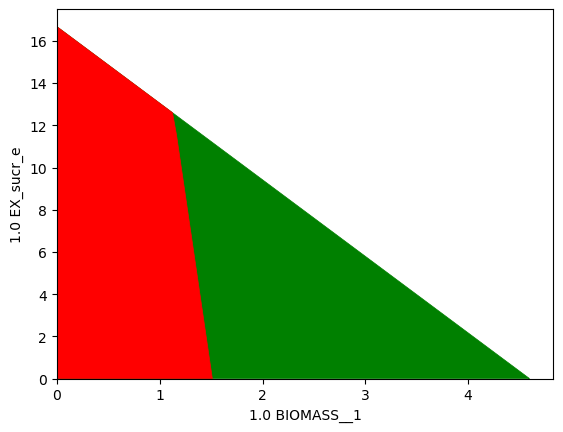

EX_photon410_e   -1000.000
EX_photon530_e   -1000.000
H2Otu_syn         -284.783
Htcx              -284.499
PPK               -283.908
                    ...   
ETAPCPSII         1000.000
PSICSum           1000.000
PSIum             1000.000
PHOA410um         1000.000
ETCPC             1000.000
Name: fluxes, Length: 449, dtype: float64

In [27]:
red_costs = run_with_intervention(['GND', 'PSP_L', 'BCT1_syn'])

red_costs[np.abs(red_costs)>0.001].sort_values()

In [ ]:
"""
['SYNPCC7942_RS07615',
 'SYNPCC7942_RS07605',
 'SYNPCC7942_RS07620',
 'SYNPCC7942_RS07610']
 
"""
[g.id for g in model.reactions.BCT1_syn.genes]

In [48]:
all_out = ''
for r in rxns:
    #print(r)
    genes = ''
    for rxn in r:
        g2 = set([g.id for g in model.reactions.get_by_id(rxn).genes])
        g2 = '|'.join(g2)
        genes +=  g2 + ' and ' 
    all_out+=genes.rstrip(' and')
    all_out+='\n'
print(all_out.replace('SYNPCC7942_', ''))

RS08980|RS08975 and RS07620|RS07610|RS07615|RS07605 and RS05090 and RS06355
RS08980|RS08975 and RS07620|RS07610|RS07615|RS07605 and RS05090 and RS06330
RS08980|RS08975 and RS07620|RS07610|RS07615|RS07605 and RS05090 and RS06335|RS06340|RS06345|RS06350
RS08980|RS08975 and RS07620|RS07610|RS07615|RS07605 and RS05090 and RS00195 and RS02470
RS08980|RS08975 and RS07620|RS07610|RS07615|RS07605 and RS05090 and RS00195 and RS07670
RS08980|RS08975 and RS07620|RS07610|RS07615|RS07605 and RS05090 and RS00195 and RS00970
RS08980|RS08975 and RS07620|RS07610|RS07615|RS07605 and RS05090 and RS11865 and RS02470
RS08980|RS08975 and RS07620|RS07610|RS07615|RS07605 and RS05090 and RS11865 and RS07670
RS08980|RS08975 and RS07620|RS07610|RS07615|RS07605 and RS05090 and RS11865 and RS00970
RS08980|RS08975 and RS07620|RS07610|RS07615|RS07605 and RS05090 and RS02690 and RS02470
RS08980|RS08975 and RS07620|RS07610|RS07615|RS07605 and RS05090 and RS02690 and RS07670
RS08980|RS08975 and RS07620|RS07610|RS07615|

In [51]:
!pip install networkx

   ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
    --------------------------------------- 0.0/1.6 MB ? eta -:--:--
    --------------------------------------- 0.0/1.6 MB ? eta -:--:--
    --------------------------------------- 0.0/1.6 MB ? eta -:--:--
   - -------------------------------------- 0.1/1.6 MB 459.5 kB/s eta 0:00:04
   - -------------------------------------- 0.1/1.6 MB 459.5 kB/s eta 0:00:04
   - -------------------------------------- 0.1/1.6 MB 459.5 kB/s eta 0:00:04
   -- ------------------------------------- 0.1/1.6 MB 327.7 kB/s eta 0:00:05
   --- ------------------------------------ 0.1/1.6 MB 473.7 kB/s eta 0:00:04
   --- ------------------------------------ 0.1/1.6 MB 473

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
magine 0.1.5 requires bioservices, which is not installed.
magine 0.1.5 requires ipywidgets, which is not installed.
magine 0.1.5 requires jupyter, which is not installed.
magine 0.1.5 requires pathos, which is not installed.
magine 0.1.5 requires plotly==2.7, which is not installed.
magine 0.1.5 requires py2cytoscape, which is not installed.
magine 0.1.5 requires pycairo, which is not installed.
magine 0.1.5 requires pydot, which is not installed.
magine 0.1.5 requires pydotplus, which is not installed.
magine 0.1.5 requires sortedcontainers, which is not installed.
magine 0.1.5 requires wordcloud, which is not installed.
magine 0.1.5 requires xlrd, which is not installed.
magine 0.1.5 requires matplotlib==3.1.0, but you have matplotlib 3.8.2 which is incompatible.
magine 0.1.5 requires networkx<2.4,>=2.1, but yo

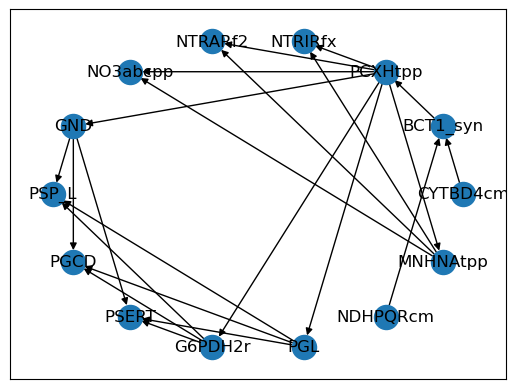

In [52]:
import networkx as nx
rxn_graph = nx.DiGraph()
for i in rxns:
    prev = None
    for j in i:
        if prev is not None:
            rxn_graph.add_edge(prev, j)
        prev = j
            
#     print(i)
nx.draw_networkx(rxn_graph, pos=nx.layout.kamada_kawai_layout(rxn_graph, rxn_graph.nodes))

In [ ]:
[g.id for g in model.reactions.BCT1_syn.genes]

['BCT1_syn']
BCT1_syn: atp_c + h2o_c + hco3_p --> adp_c + h_c + hco3_c + pi_c
4.595313108153129


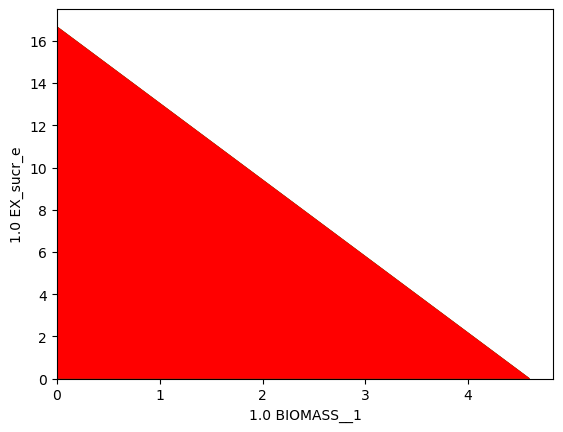

EX_photon530_e   -1000.000
EX_photon410_e   -1000.000
EX_photon690_e    -670.859
H2Otu_syn         -500.000
Htcx              -397.502
                    ...   
PHOA410um         1000.000
ETAPCPSII         1000.000
PSIICSum          1000.000
PSIum             1000.000
ETCPC             1000.000
Name: fluxes, Length: 447, dtype: float64

In [28]:
red_costs = run_with_intervention(['BCT1_syn'])
red_costs[np.abs(red_costs)>0.001].sort_values()

In [83]:
red_costs[np.abs(red_costs)>0.001].loc['HCO3E_1_cx']

183.52300375243226

['PSP_L']
PSP_L: h2o_c + pser__L_c --> pi_c + ser__L_c
2.4405745474963054


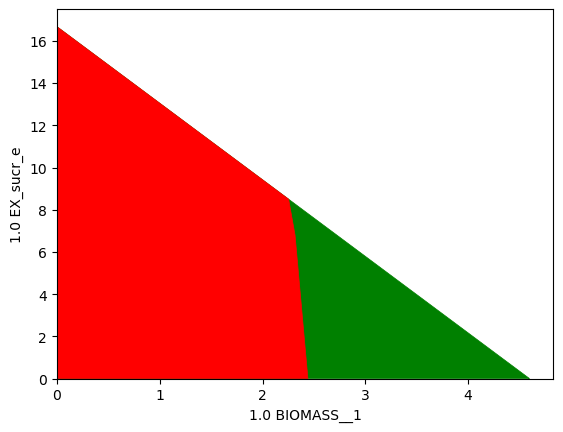

EX_photon530_e   -1000.000
EX_photon410_e   -1000.000
EX_photon690_e    -670.859
H2Otu_syn         -500.000
Htcx              -459.579
                    ...   
PSICSum           1000.000
ETAPCPSII         1000.000
ETCPC             1000.000
PHOA530um         1000.000
PSIum             1000.000
Name: fluxes, Length: 423, dtype: float64

In [29]:
red_costs = run_with_intervention(['PSP_L'])
red_costs[np.abs(red_costs)>0.005].sort_values()

['CYTBD4cm', 'BCT1_syn', 'PCXHtpp', 'GND', 'PSP_L']
CYTBD4cm: 4.0 h_c + o2_c + 2.0 pqh2_cm --> 2.0 h2o_c + 4.0 h_p + 2.0 pq_cm
BCT1_syn: atp_c + h2o_c + hco3_p --> adp_c + h_c + hco3_c + pi_c
PCXHtpp: h_c --> h_p
GND: 6pgc_c + nadp_c --> co2_c + nadph_c + ru5p__D_c
PSP_L: h2o_c + pser__L_c --> pi_c + ser__L_c
1.209505461320885


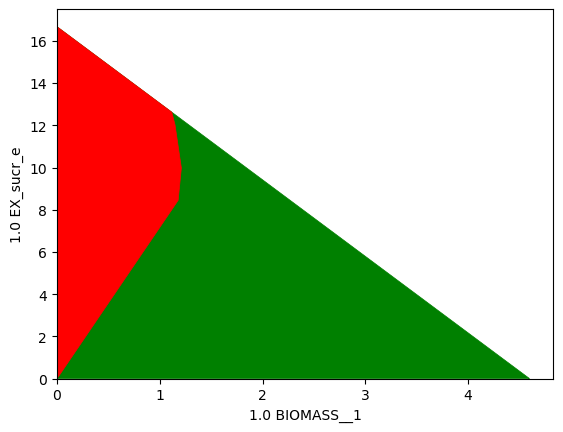

EX_photon410_e   -1000.000
EX_photon530_e    -978.579
PPK               -256.749
Htcx              -227.759
3OAR180           -224.150
                    ...   
ETCPC              978.579
PHOA530um          978.579
PSICSum           1000.000
PSIum             1000.000
PHOA410um         1000.000
Name: fluxes, Length: 448, dtype: float64

In [30]:
red_costs = run_with_intervention(rxns[3])
red_costs[np.abs(red_costs)>0.001].sort_values()

['H2CO3_NAt_syn', 'NAt3pp', 'NDH_1_4_um_copy1']
H2CO3_NAt_syn: hco3_p + na1_p <=> hco3_c + na1_c
NAt3pp: h_p + na1_c <=> h_c + na1_p
NDH_1_4_um_copy1: co2_c + 2.0 fdxrd_c + h2o_c + 4.0 h_c + pq_um --> 2.0 fdxox_c + 3.0 h_u + hco3_c + pqh2_um
0.0


C:\Users\pino216\PycharmProjects\straindesign\straindesign\lptools.py:902: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plot1.axes.set_xlim(ax_limits[0][0] * 1.05, ax_limits[0][1] * 1.05)


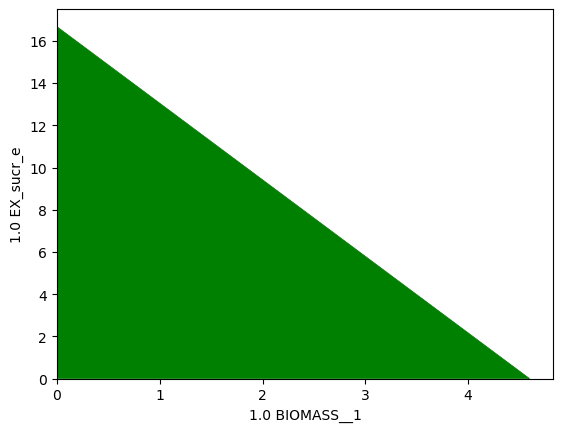

EX_hco3_e    -100.000
ADPT            0.000
O2tcx           1.010
AOXPBDC         0.000
DNTPPA          0.000
               ...   
FACOAL160i      0.000
FACOAL161i      0.000
FACOAL180i      0.000
FACOAL181i      0.000
FACOAL80i       0.000
Name: fluxes, Length: 762, dtype: float64

In [26]:
rxns2 = [
{'ADSK': -1.0, 'NADS2': -1.0},
{'ADSK': -1.0, 'NNATr': -1.0},
{'H2CO3_NAt_syn': -1.0, 'NAt3pp': -1.0, 'NDH_1_4_um_copy1': -1.0},
{'H2CO3_NAt_syn': -1.0, 'Kabcpp': -1.0, 'NAt3pp': -1.0, 'NDH_1_4_um_copy1': -1.0},
{'GLUSfx': -1.0, 'ALAD_L': -1.0, 'H2CO3_NAt_syn': -1.0, 'NAt3pp': -1.0},
{'H2CO3_NAt_syn': -1.0, 'Kabcpp': -1.0, 'ACS': -1.0, 'NAt3pp': -1.0, 'NDH_1_4_um_copy1': -1.0},
{'GLUSfx': -1.0, 'ALAD_L': -1.0, 'H2CO3_NAt_syn': -1.0, 'Kabcpp': -1.0, 'NAt3pp': -1.0},
{'ALAALAr': -1.0, 'ME2': -1.0, 'GART': -1.0, 'FDH6': -1.0, 'DCTPD': -1.0},
{'ALAALAr': -1.0, 'ME2': -1.0, 'GART': -1.0, 'FDH6': -1.0, 'NDPK6': -1.0},
{'GK1': -1.0, 'GLUSfx': -1.0, 'SUCDum': -1.0, 'CAT': -1.0, 'NADS2': -1.0},
{'GK1': -1.0, 'GLUSfx': -1.0, 'SUCDum': -1.0, 'CAT': -1.0, 'NNATr': -1.0},
{'H2CO3_NAt_syn': -1.0, 'NAt3pp': -1.0, 'AGM4PH': -1.0, 'NDH_1_4_um_copy1': -1.0, 'LALGP': -1.0},
{'H2CO3_NAt_syn': -1.0, 'NAt3pp': -1.0, 'AGM4PH': -1.0, 'NDH_1_4_um_copy1': -1.0, 'LADGMDH': -1.0},
{'H2CO3_NAt_syn': -1.0, 'NAt3pp': -1.0, 'AGM4PH': -1.0, 'NDH_1_4_um_copy1': -1.0, 'ALAGLUE': -1.0},
{'GLYCL': -1.0, 'ALAALAr': -1.0, 'IPDDI': -1.0, 'GTHPi': -1.0, 'AGM4PCP': -1.0},
{'GLYCL': -1.0, 'ALAALAr': -1.0, 'IPDDI': -1.0, 'GTHPi': -1.0, 'AGM3PH': -1.0},
{'GLYCL': -1.0, 'ALAALAr': -1.0, 'IPDDI': -1.0, 'GTHOr': -1.0, 'AGM4PCP': -1.0},
{'GLYCL': -1.0, 'ALAALAr': -1.0, 'IPDDI': -1.0, 'GTHOr': -1.0, 'AGM3PH': -1.0},
]

run_with_intervention(rxns2[2])

## Optcouple

In [127]:
module_optcouple = sd.SDModule(
    consistent_model,
    sd.names.OPTCOUPLE,
    inner_objective='BIOMASS__1',
    prod_id='EX_sucr_e',
    min_gcp=0.5
)